Lo prmiero que hay que ahcer, creamos dos pipelines, en las dos cargamos el csv, en una pasamos las columna de varaibles categoricas a ordinalidad, en la otra hacemos un one hot encoding. (El one hto encodigin es malillo porque perdemos la informacion de de cual es mas caliente o frio y la distantcion entre la que estas, mejor es usar la ordinalidad).Luego en ambas hacemos un Pca, hay que hacer pca con parametros de 95% de la varianza de los datos. Y ya despues clustering.

## Random seed tiene que ser igual a un NIA 

In [137]:
import random
import numpy as np

nia = 100472111

# Establece la semilla para el generador de números aleatorios de Python
random.seed(nia)

# También puedes establecer la semilla para NumPy
np.random.seed(nia)

## Programar K-MEANS

La primera parte consiste en crear nuestro propio método K-means, para lo cual debemos implementar varios submétodos clave: inicialización de centroides (por qué es importante), asignación de clusters (por qué se necesita), actualización de centroides (por qué es esencial) y, por último, el método K-means en sí mismo (por qué lo usamos). Para evaluar la eficiencia de nuestro modelo en comparación con el K-means original, utilizaremos el método make_blobs para crear un ejemplo básico con el que se pueda asociar clusters. Posteriormente, usaremos métricas de tiempo y el "silhouette score" para comparar resultados.

Algunos problemas que hemos encontrado son los siguientes: al usar un valor de cluster_std = 1.0, que es una estandarización fuerte, la precisión del resultado puede depender en gran medida de cómo se inicialicen los centroides. Por ello, en ocasiones, la primera ejecución no funcionaba correctamente según lo planteado por sklearn. Para abordar este problema, hemos añadido a nuestro método de inicialización de centroides la estrategia K-means++ (y explicamos por qué), lo que ha mejorado significativamente el rendimiento de nuestro algoritmo K-means.

Comparación entre k-means personalizado y scikit-learn:
Tiempo de ejecución (personalizado): 0.0010018348693847656 segundos
Silhouette score (personalizado): 0.7542569524018364
Tiempo de ejecución (scikit-learn): 0.004999876022338867 segundos
Silhouette score (scikit-learn): 0.7542569524018364


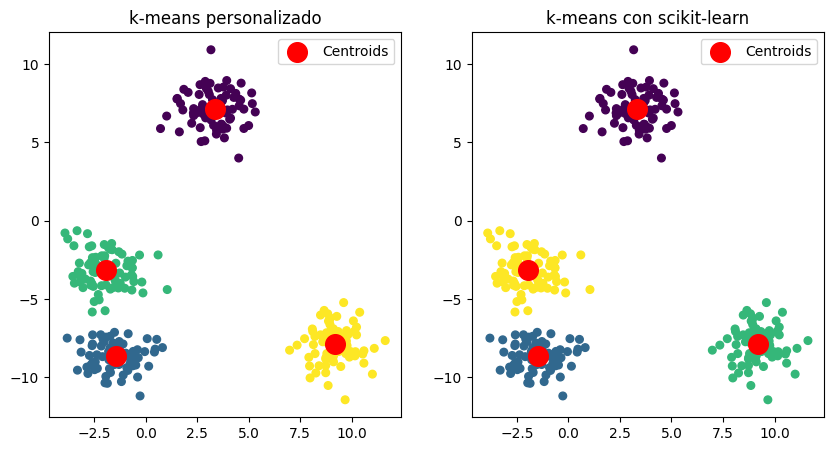

In [138]:
import numpy as np
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans as SKLearnKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import time

# Crear datos de ejemplo
num_samples = 300
num_features = 2
num_clusters = 4

data, _ = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=1.0, random_state=100451958)

# Elegir centros iniciales aleatorios
def initialize_centroids(data, k):
    # Escoger el primer centroide al azar
    centroids = [data[random.randint(0, len(data) - 1)]]

    # Escoger el resto de los centroides usando el método K-Means++
    for _ in range(1, k):
        distances = np.min(np.linalg.norm(data[:, np.newaxis] - np.array(centroids), axis=2), axis=1)
        probabilities = distances / distances.sum()
        new_centroid_index = np.random.choice(range(len(data)), p=probabilities)
        centroids.append(data[new_centroid_index])

    return np.array(centroids)

# Asignar puntos a los clústeres
def assign_clusters(data, centroids):
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

# Actualizar los centros de los clústeres
def update_centroids(data, labels, k):
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

# Función para el algoritmo k-means
def kmeans(data, k, num_iterations=10000, tolerance=1e-4):

    centroids = initialize_centroids(data, k)

    for _ in range(num_iterations):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)

        # Chequeo de convergencia
        if np.linalg.norm(centroids - new_centroids) < tolerance:
            break

        centroids = new_centroids

    return centroids, labels


#Comparación entre k-means personalizado y scikit-learn
start_time = time.time()
centroids_custom, labels_custom = kmeans(data, num_clusters)
custom_time = time.time() - start_time
silhouette_custom = silhouette_score(data, labels_custom)

start_time = time.time()
sklearn_kmeans = SKLearnKMeans(n_clusters=num_clusters, random_state=100451958).fit(data)
labels_sklearn = sklearn_kmeans.labels_
centroids_sklearn = sklearn_kmeans.cluster_centers_
sklearn_time = time.time() - start_time
silhouette_sklearn = silhouette_score(data, labels_sklearn)

# Mostrar resultados
print("Comparación entre k-means personalizado y scikit-learn:")
print("Tiempo de ejecución (personalizado):", custom_time, "segundos")
print("Silhouette score (personalizado):", silhouette_custom)

print("Tiempo de ejecución (scikit-learn):", sklearn_time, "segundos")
print("Silhouette score (scikit-learn):", silhouette_sklearn)

# Visualizar resultados
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("k-means personalizado")
plt.scatter(data[:, 0], data[:, 1], c=labels_custom, cmap='viridis', s=30)
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], c='red', s=200, label='Centroids')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("k-means con scikit-learn")
plt.scatter(data[:, 0], data[:, 1], c=labels_sklearn, cmap='viridis', s=30)
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], c='red', s=200, label='Centroids')
plt.legend()


plt.show()

# Preprocesado

Primero cargamos el archivo CSV y realizamos los ajustes necesarios. Como primer paso, visualizamos los datos para identificar las variables categóricas y examinamos sus valores para entender mejor su contenido y estructura.

In [139]:
import pandas as pd

df = pd.read_csv("Stars2.csv")
unique_colors = df['Color'].unique()
unique_spectral_classes = df['Spectral_Class'].unique()

print("Clases únicas para 'color':", unique_colors)
print("Clases únicas para 'Spectral_class':", unique_spectral_classes)

# Visualizar
df.head()


Clases únicas para 'color': ['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']
Clases únicas para 'Spectral_class': ['M' 'B' 'A' 'F' 'O' 'K' 'G']


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


Una vez visto que colo no tiene buenos colores o lagunos son los mimso pero con distinto nombres pues le aplicamos un color mappin para restrucutrar los datos, a su vez vemos los datos faltantes al mas puro prepocesado basico

In [140]:
color_mapping = {
    "Blue White": "Blue-White",
    "Blue white": "Blue-White",
    "Blue-white": "Blue-White",
    "White-Yellow": "White-Yellow",
    "yellow-white": "White-Yellow",
    "yellowish": "Yellowish",
	"white": "White",
}

# Aplicar el mapeo a la columna de color
df["Color"] = df["Color"].replace(color_mapping)

# Obtener las nuevas clases únicas para verificar la fusión
unique_colors = df["Color"].unique()
print("Clases únicas después de fusionar similares:", unique_colors)

Clases únicas después de fusionar similares: ['Red' 'Blue-White' 'White' 'Yellowish White' 'Pale yellow orange' 'Blue'
 'Whitish' 'White-Yellow' 'Orange' 'Yellowish' 'Orange-Red']


Tambien confirmamos que todos los datos se ven correctamente

In [141]:
print("Número de instancias y características:")
print(df.shape)
print("Valores faltantes:")
print(df.isnull().sum())
constantes = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes:")
print(constantes)

Número de instancias y características:
(240, 6)
Valores faltantes:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64
Columnas constantes:
[]


## DataFrames con las cuatro combinaciones posibles para transformar columnas categóricas

Vamos a crear diferentes DataFrames con las cuatro combinaciones posibles para transformar columnas categóricas. Para ello, diseñaremos pipelines distintas que permitan convertir cada grupo de columnas categóricas, ya sea utilizando codificación ordinal o one-hot encoding. Esto nos dará flexibilidad para experimentar con distintas formas de procesar las variables categóricas y evaluar su impacto.

In [142]:
from sklearn.preprocessing import OrdinalEncoder

# Definir el orden para el OrdinalEncoder
color_order = ["Red", "Orange-Red", "Orange", "Pale yellow orange", 
               "Yellowish", "Yellowish White", "White", 
               "Whitish", "White-Yellow", "Blue-White", "Blue"]

spectral_class_order = ['M', 'K', 'G', 'F', 'A', 'B', 'O']

# Crear un OrdinalEncoder con orden específico
ordinal_encoder = OrdinalEncoder(categories=[color_order, spectral_class_order])

# Aplicar OrdinalEncoder a las columnas categóricas
df_ordinal = df.copy()
df_ordinal[['Color', 'Spectral_Class']] = ordinal_encoder.fit_transform(df[['Color', 'Spectral_Class']])

# Mostrar el DataFrame con valores ordinales
print("DataFrame con columnas categóricas convertidas a ordinalidad:")
df_ordinal.head()


DataFrame con columnas categóricas convertidas a ordinalidad:


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,0.0,0.0
1,3042,0.000500,0.1542,16.60,0.0,0.0
2,2600,0.000300,0.1020,18.70,0.0,0.0
3,2800,0.000200,0.1600,16.65,0.0,0.0
4,1939,0.000138,0.1030,20.06,0.0,0.0


In [143]:
# Crear el dataframe con One-Hot Encoding
df_one_hot = pd.get_dummies(df.copy(), columns=['Color', 'Spectral_Class'])

# Convertir las columnas booleanas a valores 0 y 1
df_one_hot = df_one_hot.astype(int)

print("DataFrame con One-Hot Encoding usando 0 y 1:")
df_one_hot.head()



DataFrame con One-Hot Encoding usando 0 y 1:


,Temperature,L,R,A_M,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,...,Color_Whitish,Color_Yellowish,Color_Yellowish White,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [144]:
# Ordinalidad para "color"
ordinal_encoder = OrdinalEncoder(categories=[color_order])

df_oc_ohes = df.copy()
df_oc_ohes['Color'] = ordinal_encoder.fit_transform(df[['Color']])

# One-Hot Encoding para "Spectral_class"
df_oc_ohes = pd.get_dummies(df_oc_ohes, columns=['Spectral_Class'])

# Convertir booleanos a ceros y unos
df_mixed_1 = df_oc_ohes.astype(int)

print("DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:")
df_mixed_1.head()



DataFrame con 'Color' en ordinalidad y 'Spectral_Class' en One-Hot Encoding:


,Temperature,L,R,A_M,Color,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,3068,0,0,16,0,0,0,0,0,0,1,0
1,3042,0,0,16,0,0,0,0,0,0,1,0
2,2600,0,0,18,0,0,0,0,0,0,1,0
3,2800,0,0,16,0,0,0,0,0,0,1,0
4,1939,0,0,20,0,0,0,0,0,0,1,0


In [145]:
# One-Hot Encoding para "color"
df_ohec_os = pd.get_dummies(df, columns=['Color'])

ordinal_encoder = OrdinalEncoder(categories=[spectral_class_order])
# Ordinalidad para "Spectral_class"
df_ohec_os['Spectral_Class'] = ordinal_encoder.fit_transform(df[['Spectral_Class']])

# Convertir booleanos a ceros y unos
df_mixed_2 = df_ohec_os.astype(int)

print("DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:")
df_mixed_2.head()


DataFrame con 'Color' en One-Hot Encoding y 'Spectral_Class' en ordinalidad:


,Temperature,L,R,A_M,Spectral_Class,Color_Blue,Color_Blue-White,Color_Orange,Color_Orange-Red,Color_Pale yellow orange,Color_Red,Color_White,Color_White-Yellow,Color_Whitish,Color_Yellowish,Color_Yellowish White
0,3068,0,0,16,0,0,0,0,0,0,1,0,0,0,0,0
1,3042,0,0,16,0,0,0,0,0,0,1,0,0,0,0,0
2,2600,0,0,18,0,0,0,0,0,0,1,0,0,0,0,0
3,2800,0,0,16,0,0,0,0,0,0,1,0,0,0,0,0
4,1939,0,0,20,0,0,0,0,0,0,1,0,0,0,0,0


## PCA


Después de crear los cuatro DataFrames con todas sus variaciones, aplicamos el Análisis de Componentes Principales (PCA). Este proceso nos ayuda a visualizar los datos de manera más clara, ya que reduce las dimensiones a solo dos columnas, que son combinaciones lineales de todas las columnas originales. Esto simplifica la visualización y el análisis, permitiéndonos entender mejor las estructuras subyacentes y las relaciones entre variables

Hemos omitido la primera salida del PCA pero nos salio muy parecida entre ellos. Una posible razón por la que las gráficas se parecen tanto podría ser que los parámetros de "color" y "spectral class" no tienen un impacto significativo en la varianza, por lo que su codificación no hace mucha diferencia. Sin embargo, para tener más certeza, vamos a escalar los datos para ver si eso arroja un resultado más claro.

In [146]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Crear el StandardScaler
scaler = StandardScaler()

# Escalar los DataFrames
df_mixed_1_scaled = scaler.fit_transform(df_mixed_1)
df_mixed_2_scaled = scaler.fit_transform(df_mixed_2)
df_ordinal_scaled = scaler.fit_transform(df_ordinal)
df_one_hot_scaled = scaler.fit_transform(df_one_hot)

pca = PCA(n_components=2) 

df_mixed_1_pca = pca.fit_transform(df_mixed_1_scaled)
df_mixed_2_pca = pca.fit_transform(df_mixed_2_scaled)
df_ordinal_pca = pca.fit_transform(df_ordinal_scaled)
df_one_hot_pca = pca.fit_transform(df_one_hot_scaled)


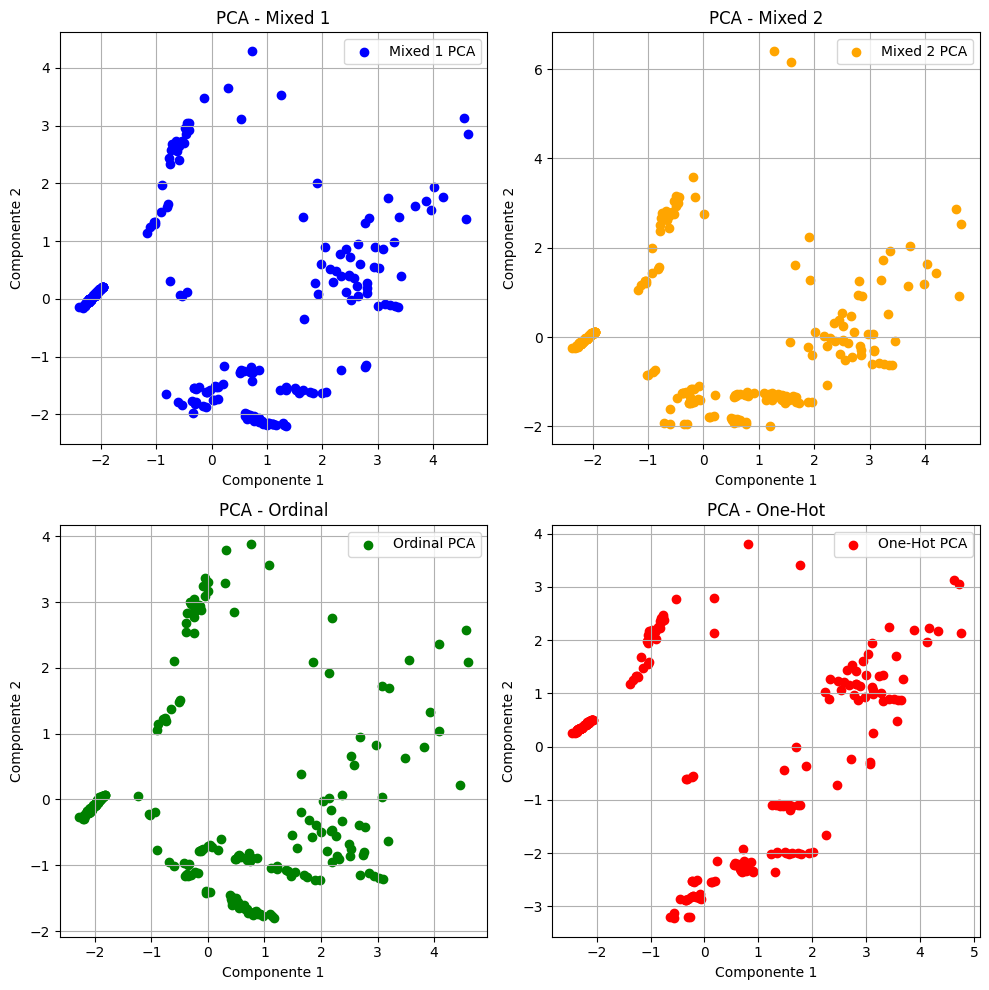

In [159]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))  # Crear un grid de 2x2

# Primer gráfico (arriba a la izquierda)
ax[0, 0].scatter(df_mixed_1_pca[:, 0], df_mixed_1_pca[:, 1], c='blue', label='Mixed 1 PCA')
ax[0, 0].set_title('PCA - Mixed 1')
ax[0, 0].set_xlabel('Componente 1')
ax[0, 0].set_ylabel('Componente 2')
ax[0, 0].legend()
ax[0, 0].grid(True)

# Segundo gráfico (arriba a la derecha)
ax[0, 1].scatter(df_mixed_2_pca[:, 0], df_mixed_2_pca[:, 1], c='orange', label='Mixed 2 PCA')
ax[0, 1].set_title('PCA - Mixed 2')
ax[0, 1].set_xlabel('Componente 1')
ax[0, 1].set_ylabel('Componente 2')
ax[0, 1].legend()
ax[0, 1].grid(True)

# Tercer gráfico (abajo a la izquierda)
ax[1, 0].scatter(df_ordinal_pca[:, 0], df_ordinal_pca[:, 1], c='green', label='Ordinal PCA')
ax[1, 0].set_title('PCA - Ordinal')
ax[1, 0].set_xlabel('Componente 1')
ax[1, 0].set_ylabel('Componente 2')
ax[1, 0].legend()
ax[1, 0].grid(True)

# Cuarto gráfico (abajo a la derecha)
ax[1, 1].scatter(df_one_hot_pca[:, 0], df_one_hot_pca[:, 1], c='red', label='One-Hot PCA')
ax[1, 1].set_title('PCA - One-Hot')
ax[1, 1].set_xlabel('Componente 1')
ax[1, 1].set_ylabel('Componente 2')
ax[1, 1].legend()
ax[1, 1].grid(True)


plt.tight_layout()
plt.show()


Ahora parece que tiene mas sentido vamos a continuar con estos datos

## Aplicar Algortimo de CLustering

### Método Silhouette
Algunas veces, con el método Elbow es difícil determinar en número óptimo de clusters. Otra aproximación es el método Silhouette. Utiliza la distancia media intraclúster y la distancia media clúster más cercano para cada muestra. Cuanto mayor sea el valor de la puntuación, mejor será la estimación. Normalmente, las puntuaciones de silhoutte suben y luego bajan hasta alcanzar un número óptimo de clusters. Los valores se sitúan entre -1,0 y 1,0.

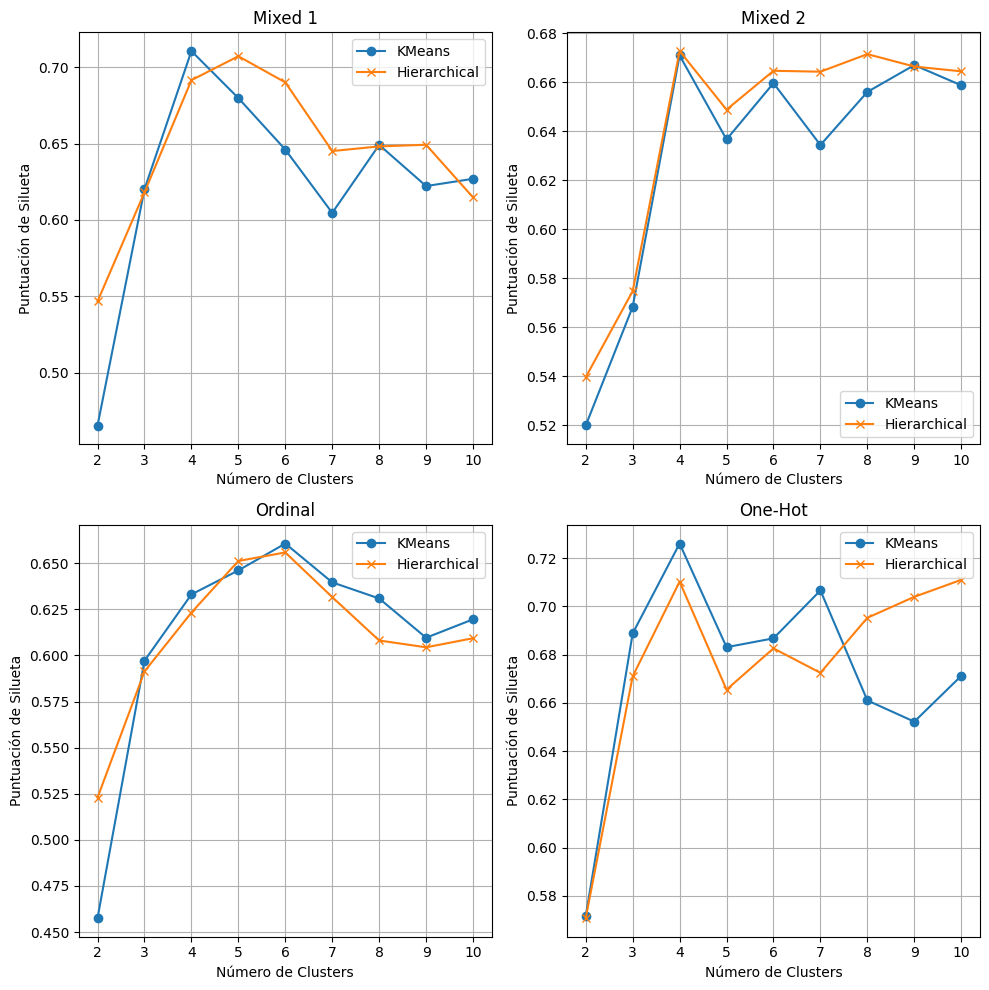

In [165]:
# Rango de número de clusters para probar
k_range = range(2, 11)

def my_silhouette_scores(df):
    silhouette_scores = []
    for k in k_range:
        kmeans = SKLearnKMeans(n_clusters=k, random_state=100472111)
        cluster_labels = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

def my_silhouette_score_hierarchical(df):
    silhouette_scores = []
    for k in k_range:
        hierarchical = AgglomerativeClustering(n_clusters=k)
        cluster_labels = hierarchical.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores


# Aplicar la función a los DataFrames
dataframes = [df_mixed_1_pca, df_mixed_2_pca, df_ordinal_pca, df_one_hot_pca]
titles = ["Mixed 1", "Mixed 2", "Ordinal", "One-Hot"]

# Crear un grid de 2x2 para los gráficos
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, df, title in zip(axes.flatten(), dataframes, titles):
    # Calcular las puntuaciones de silueta para KMeans y Clustering Jerárquico
    scores_kmeans = my_silhouette_scores(df)
    scores_hierarchical = my_silhouette_score_hierarchical(df)
    
    # Graficar las puntuaciones de silueta
    ax.plot(list(k_range), scores_kmeans, label='KMeans', marker='o')
    ax.plot(list(k_range), scores_hierarchical, label='Hierarchical', marker='x')
    
    # Títulos y etiquetas
    ax.set_title(title)
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Puntuación de Silueta")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


Los resultados sugieren que el número óptimo de clusters es 4 para la mayoría de los casos, excepto en el conjunto de datos ordinal, donde el número óptimo es 6. Veamos cómo se comportan estos valores cuando aplicamos el clustering

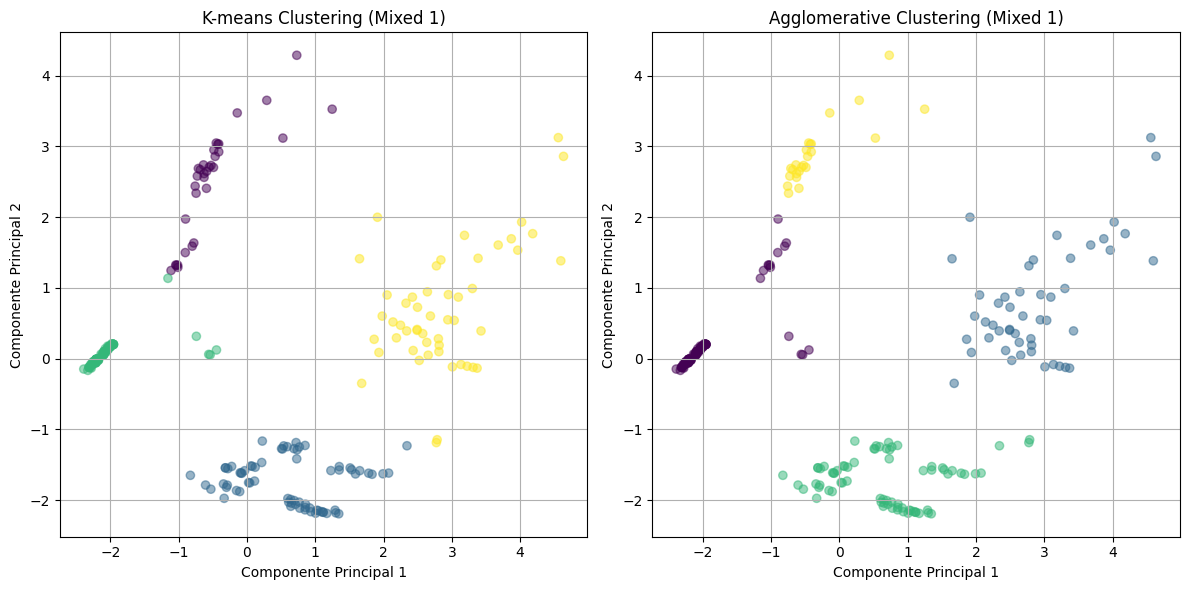

Silhouette Score para K-means (Mixed 1): 0.711
Silhouette Score para Agglomerative Clustering (Mixed 1): 0.692


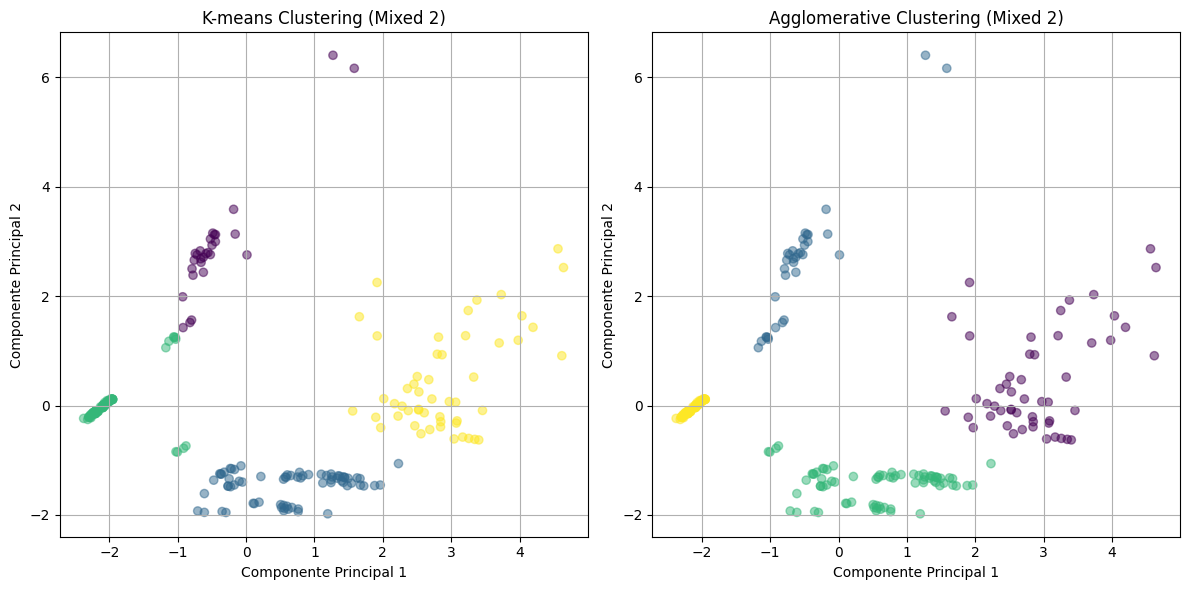

Silhouette Score para K-means (Mixed 2): 0.671
Silhouette Score para Agglomerative Clustering (Mixed 2): 0.673


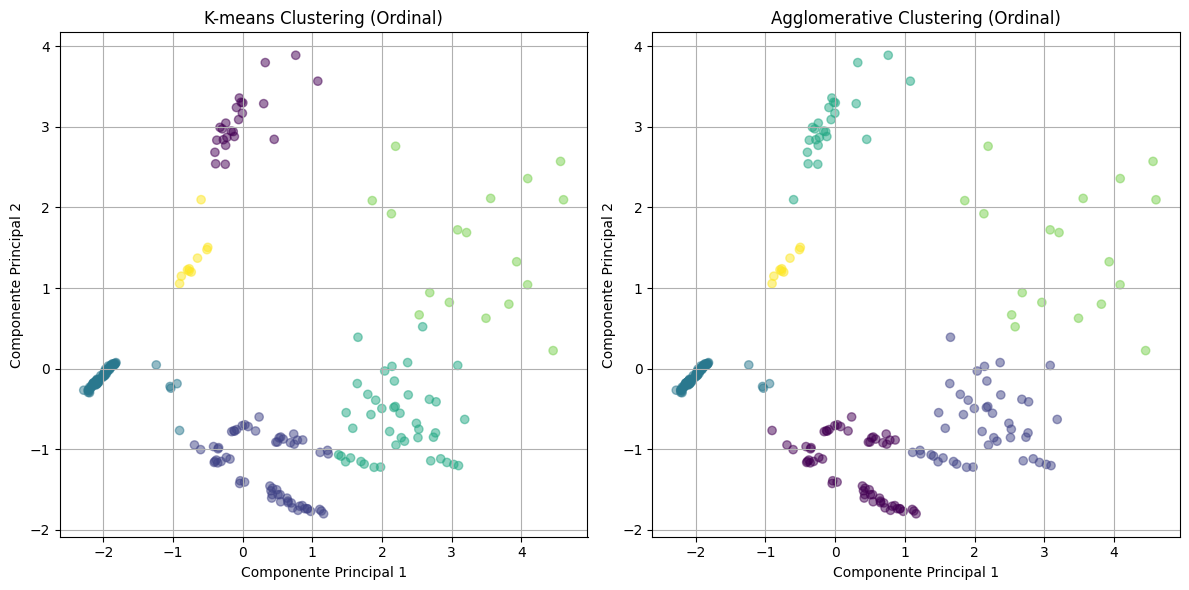

Silhouette Score para K-means (Ordinal): 0.661
Silhouette Score para Agglomerative Clustering (Ordinal): 0.656


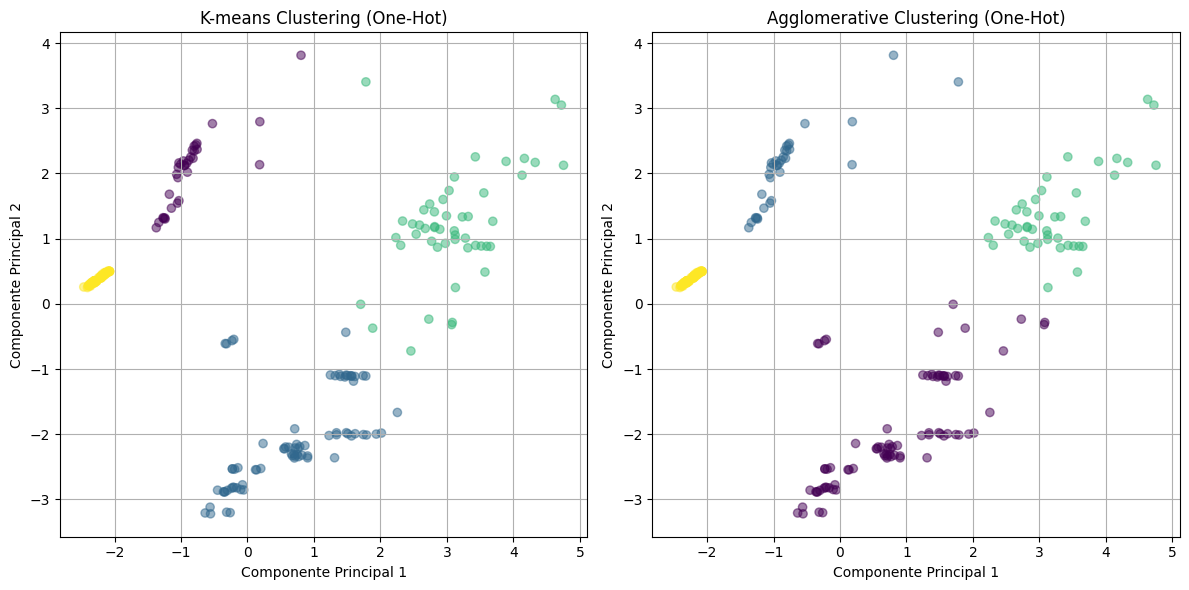

Silhouette Score para K-means (One-Hot): 0.726
Silhouette Score para Agglomerative Clustering (One-Hot): 0.710


In [174]:

# Número de clusters para cada tipo de conjunto de datos
num_clusters = {
    "Ordinal": 6,  # Número de clusters específico para el conjunto ordinal
    "default": 4   # Número de clusters para el resto
}


# Ciclo para aplicar K-means y Agglomerative Clustering a cada DataFrame
for df, title in zip(dataframes, titles):
    # Determinar el número de clusters basándose en el título del conjunto de datos
    n_clusters = num_clusters.get(title, num_clusters["default"])

    
    kmeans = SKLearnKMeans(n_clusters=n_clusters, random_state=100472111)
    kmeans_labels = kmeans.fit_predict(df)
    
    
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agglomerative_labels = agglomerative.fit_predict(df)
    
    
    plt.figure(figsize=(12, 6))  # Crear una figura con dos subgráficos
    
    # Gráfico para K-means
    plt.subplot(1, 2, 1)
    plt.grid(True)
    plt.scatter(df[:, 0], df[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"K-means Clustering ({title})")
    
    # Gráfico para Agglomerative Clustering
    plt.subplot(1, 2, 2)
    plt.grid(True)
    plt.scatter(df[:, 0], df[:, 1], c=agglomerative_labels, cmap='viridis', alpha=0.5)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.title(f"Agglomerative Clustering ({title})")

    plt.tight_layout()
    plt.show()

    # Calcular el Silhouette Score para cada método de clustering
    kmeans_silhouette = silhouette_score(df, kmeans_labels)
    agglomerative_silhouette = silhouette_score(df, agglomerative_labels)

    print(f"Silhouette Score para K-means ({title}): {kmeans_silhouette:.3f}")
    print(f"Silhouette Score para Agglomerative Clustering ({title}): {agglomerative_silhouette:.3f}")

Resultados para "Mixed 1"
K-means: Con un Silhouette Score de 0.711, el clustering parece estar bien definido, con una buena separación entre los clusters.
Agglomerative Clustering: El puntaje es 0.692, ligeramente inferior al de K-means, pero aún indica una buena agrupación.
En general, ambos algoritmos muestran un resultado sólido para esta configuración, con K-means apenas superando a Agglomerative Clustering.

Resultados para "Mixed 2"
K-means: El puntaje es de 0.671, sugiriendo que hay cierta superposición entre clusters, pero en general el agrupamiento es aceptable.
Agglomerative Clustering: Con un puntaje de 0.673, Agglomerative Clustering parece funcionar de manera similar a K-means para esta combinación.
En este caso, ambos algoritmos parecen proporcionar resultados comparables en términos de separación de clusters.

Resultados para "Ordinal"
K-means: Con 0.661, este es el puntaje más bajo entre todos, indicando que los clusters están menos definidos.
Agglomerative Clustering: Con un Silhouette Score de 0.656, es ligeramente inferior al de K-means, pero aún relativamente bajo.
Estos resultados sugieren que la codificación ordinal puede tener más dificultades para proporcionar una buena separación entre clusters, independientemente del algoritmo utilizado.

Resultados para "One-Hot"
K-means: Con un puntaje de 0.726, la calidad del clustering es similar a la configuración "Ordinal".
Agglomerative Clustering: Con un Silhouette Score de 0.710, Agglomerative Clustering parece tener una ventaja significativa sobre K-means en esta configuración.
Estos resultados también sugieren que la codificación One-Hot ofrece una mejor separación para Agglomerative Clustering que para K-means.


Silhouette Score: Los resultados para cada configuración indican variabilidad en la calidad del clustering, pero en general, ambos algoritmos parecen generar agrupamientos válidos. Sin embargo, la superioridad de Agglomerative Clustering en algunas combinaciones podría indicar que este algoritmo es más adecuado para ciertos tipos de datos o estructuras de clustering.

## Hay similitudes?

| Clase                     | Temperatura | L           | R             | A_M   | Color         | Clase Espectral |
|---------------------------|-------------|-------------|---------------|-------|---------------|-----------------|
| Enana roja                | 3.000       | 7,0∙10^-4   | 1,0∙10^-1     | +17.5 | rojo          | K-M             |
| Enana marrón              | 3.300       | 5,5∙10^-3   | 3,5∙10^-1     | +12.5 | rojo          | M               |
| Enana blanca              | 14.000      | 2,5∙10^-3   | 1,0∙10^-2     | +12.6 | blanca        | B-G             |
| Estrella en secuencia     | 16.000      | 3.2∙10^4    | 4,4           | -0.4  | blancaamarilla| B-M             |
| Super gigante             | 15.000      | 3.0∙10^5    | 5,0∙10^1      | -6.4  | blancaamarilla| B-M             |
| Hiper gigante             | 11.000      | 3.0∙10^5    | 1,4∙10^3      | -9.6  | amarilla      | B-M             |


Me falta por saber:
Necesito realemtne meter en una pipeline df una vez acabados?
Que tengo que discutir con los resultados? Rollo porque n_cluster segun el metodo del codo me sale que son 4 pero las clases realmetne en ciencia son 6.
